In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import category_encoders as ce

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from dask_ml.model_selection import HyperbandSearchCV

from IPython.display import display

import time

In [2]:
# 데이터 불러오기
df = pd.read_parquet('data_final.parquet').reset_index(drop=True)

In [3]:
df.head()

,region,price,model_year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,type,state,lat,long,odometer_per_age,avg_autoTheftPerPop
0,auburn,33590,2014,gmc,sierra,8,gas,57923.0,other,rwd,pickup,al,32.590,-85.4800,6435.888889,229.8
1,auburn,22590,2010,chevrolet,silverado,8,gas,71229.0,other,rwd,pickup,al,32.590,-85.4800,5479.153846,229.8
2,auburn,39590,2020,chevrolet,silverado,8,gas,19160.0,other,rwd,pickup,al,32.590,-85.4800,6386.666667,229.8
3,auburn,30990,2017,toyota,tundra,8,gas,41124.0,other,rwd,pickup,al,32.590,-85.4800,6854.0,229.8
4,auburn,15000,2013,ford,f-150 xlt,6,gas,128000.0,automatic,rwd,truck,al,32.592,-85.5189,12800.0,229.8


In [4]:
df.rename(columns={'avg_autoTheftPerPop': 'autoTheftPerPop'}, inplace=True)

In [5]:
df.nunique()

region                 335
price                13814
model_year              23
manufacturer            67
model                 6969
cylinders                9
fuel                     5
odometer             83571
transmission             3
drive                    5
type                    13
state                   47
lat                  37943
long                 38232
odometer_per_age    101964
autoTheftPerPop        314
dtype: int64

In [6]:
df['age'] = 2023 - df['model_year']

## 범주형 데이터 인코딩

In [7]:
binenc_columns = ['manufacturer', 'model']
ohenc_columns = ['fuel', 'transmission', 'drive', 'type']
numerical_columns = ['age', 'odometer_per_age', 'autoTheftPerPop', 'cylinders']
feature_columns = ['manufacturer', 'model', 'age', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'odometer_per_age', 'autoTheftPerPop']
label_column = 'price'

https://medium.com/@kevin.menear/comparing-label-encoding-one-hot-encoding-and-binary-encoding-for-handling-categorical-variables-933544ccbd02#:~:text=Information%20Loss%3A%20Binary%20encoding%20can,performance%20of%20machine%20learning%20models.

In [8]:
# ce모듈의 BinaryEncoder를 사용하여 고유값 개수가 많은 범주형 변수를 이진수로 인코딩
bin_encoder = ce.BinaryEncoder(cols=binenc_columns)
df_encoded_tmp = df.loc[:, feature_columns+[label_column]]
df_encoded = bin_encoder.fit_transform(df_encoded_tmp)

In [9]:
# sklearn의 OneHotEncoder를 사용하여 고유값 개수가 적은 범주형 변수를 인코딩
oh_encoder = OneHotEncoder(sparse_output=False)
oh_encoded = oh_encoder.fit_transform(df_encoded_tmp[ohenc_columns])
oh_encoded_df = pd.DataFrame(oh_encoded, columns=oh_encoder.get_feature_names_out(ohenc_columns))

# 인코딩된 데이터프레임을 합치기
df_encoded = pd.concat([df_encoded, oh_encoded_df], axis=1).drop(columns=ohenc_columns, axis=1)

In [10]:
df_encoded.columns

Index(['manufacturer_0', 'manufacturer_1', 'manufacturer_2', 'manufacturer_3',
       'manufacturer_4', 'manufacturer_5', 'manufacturer_6', 'model_0',
       'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6',
       'model_7', 'model_8', 'model_9', 'model_10', 'model_11', 'model_12',
       'age', 'cylinders', 'odometer_per_age', 'autoTheftPerPop', 'price',
       'fuel_diesel', 'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other',
       'transmission_automatic', 'transmission_manual', 'transmission_other',
       'drive_4wd', 'drive_awd', 'drive_fwd', 'drive_other', 'drive_rwd',
       'type_SUV', 'type_bus', 'type_convertible', 'type_coupe',
       'type_hatchback', 'type_mini-van', 'type_offroad', 'type_other',
       'type_pickup', 'type_sedan', 'type_truck', 'type_van', 'type_wagon'],
      dtype='object')

## 학습 및 예측 데이터로 분할

In [11]:
# 피쳐 컬럼 다시 정의
feature_columns_encoded = df_encoded.columns.difference([label_column])

X = df_encoded[feature_columns_encoded]
y = df_encoded[label_column]
# 학습:예측 = 8:2의 비율로 데이터를 나눈다
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 데이터 표준화

In [12]:
# 수치형 변수의 스케일을 맞추기 위해 StandardScaler를 사용
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

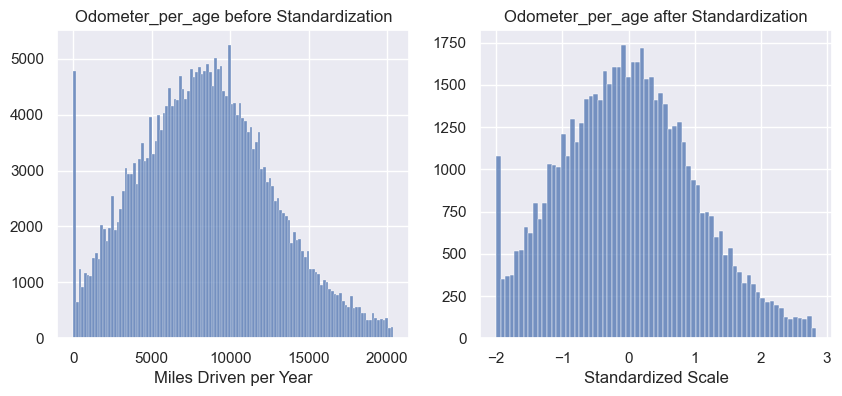

In [13]:
# 정규화하기 전후 데이터 시각화
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df_encoded['odometer_per_age'], ax=ax[0])
ax[0].set_title('Odometer_per_age before Standardization')
ax[0].set_xlabel('Miles Driven per Year')
ax[0].set_ylabel('')

sns.histplot(X_test['odometer_per_age'], ax=ax[1])
ax[1].set_title('Odometer_per_age after Standardization')
ax[1].set_xlabel('Standardized Scale')
ax[1].set_ylabel('')
plt.tight_layout
plt.show()

---
#### 모델 성능 평가 및 시각화 함수 정의

In [14]:
# 성능 평가 지표를 생성할 딕셔너리 생성
eval_metrics_dict = {}

# 모델의 성능을 평가하고 출력하는 함수
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name='Linear Regression', show_feature_importance=False):
    '''
    모델의 성능을 평가하고 출력하는 함수
    '''
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 성능 평가 지표 계산
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 성능 평가 지표를 딕셔너리에 저장
    eval_metrics_dict[model_name] = {'Train MAE': train_mae, 'Test MAE': test_mae,
                                     'Train MSE': train_mse, 'Test MSE': test_mse,
                                     'Train RMSE': train_rmse, 'Test RMSE': test_rmse,
                                     'Train R^2': train_r2, 'Test R^2': test_r2}
    
    # 성능 평가 지표를 데이터프레임으로 변환
    eval_metrics_df = pd.DataFrame(eval_metrics_dict[model_name], index=[model_name])
    
    return eval_metrics_df

In [15]:
def plt_model(model, y_test, y_pred, model_name='Linear Regression', show_feature_importance=False, n_features=7):
    '''
    모델의 예측 결과 및 피쳐 중요도 시각화 함수
    '''
    # 모델의 예측 결과 시각화
    figure, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.scatterplot(y=y_test, x=y_pred, alpha=0.5, ax=ax[0])
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    ax[0].set_xlabel("Prices: $Y_i$")
    ax[0].set_ylabel("Predicted prices: $\hat{Y}_i$")
    ax[0].set_title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$ - "+model_name)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    
    if show_feature_importance:
        # 모델의 피쳐 중요도 계산
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:min(n_features, len(importances))]  # 상위 7개 피쳐만 시각화
    
        # 모델의 피쳐 중요도 시각화
        sns.barplot(x=importances[indices], y=X.columns[indices], hue=X.columns[indices], dodge=False,
                    palette='viridis', ax=ax[1])
        ax[1].set_title(f'{model_name} Feature Importances')
        ax[1].set_xlabel('Feature Importance')
        ax[1].set_ylabel('Feature')
    else:
        # 안 쓰는 서브플롯 삭제
        figure.delaxes(ax[1])
        
    plt.tight_layout()
    plt.show

---
## 모델 학습 및 예측

### Linear Regression Model

In [83]:
# 선형 회귀 모델을 학습
lin_reg = LinearRegression()

lin_reg_columns = ['age', 'odometer_per_age', 'autoTheftPerPop', 'cylinders']

X_train_lin_reg = X_train[lin_reg_columns]
X_test_lin_reg = X_test[lin_reg_columns]
lin_reg.fit(X_train_lin_reg, np.sqrt(y_train))

LinearRegression()

In [84]:
# 선형 회귀 모델의 성능 평가
evaluate_model(lin_reg, X_train_lin_reg, X_test_lin_reg, np.sqrt(y_train), np.sqrt(y_test), 'Linear Regression')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Linear Regression,23.581575,23.573064,1241.835345,1250.968283,35.239684,35.36903,0.554691,0.553304


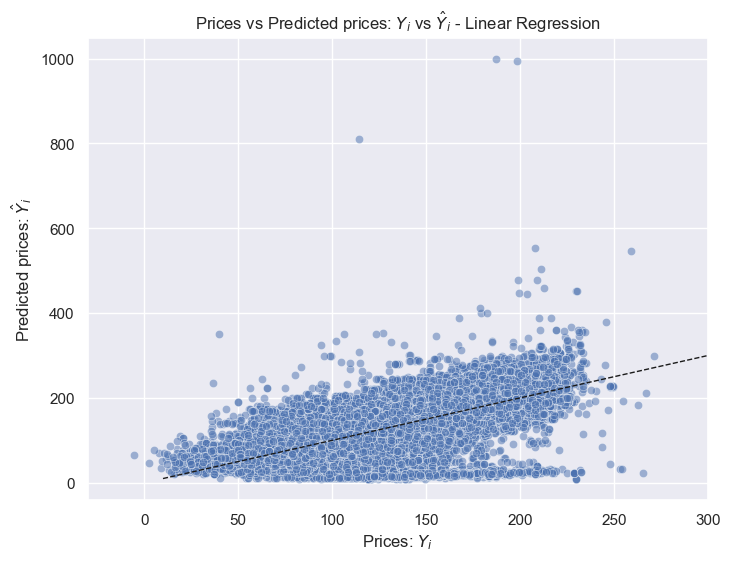

In [85]:
# 선형 회귀 모델의 예측 결과 시각화
y_test_pred_lin_reg = lin_reg.predict(X_test_lin_reg)

# 모델의 예측 결과 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(y=np.sqrt(y_test), x=y_test_pred_lin_reg, alpha=0.5)
plt.plot([np.sqrt(y_test).min(), np.sqrt(y_test).max()], [np.sqrt(y_test).min(), np.sqrt(y_test).max()], 'k--', lw=1)
plt.xlim(-30, 300)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$ - Linear Regression")
plt.show()

### Random Forest Regression Model

In [93]:
# 랜덤 포레스트 회귀 모델 학습
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [94]:
# 랜덤 포레스트 회귀 모델의 성능 평가
evaluate_model(rf_reg, X_train, X_test, y_train, y_test, 'Random Forest')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Random Forest,824.470582,2171.586579,5.654157e+06,4.563641e+07,2377.847139,6755.472703,0.976784,0.824601


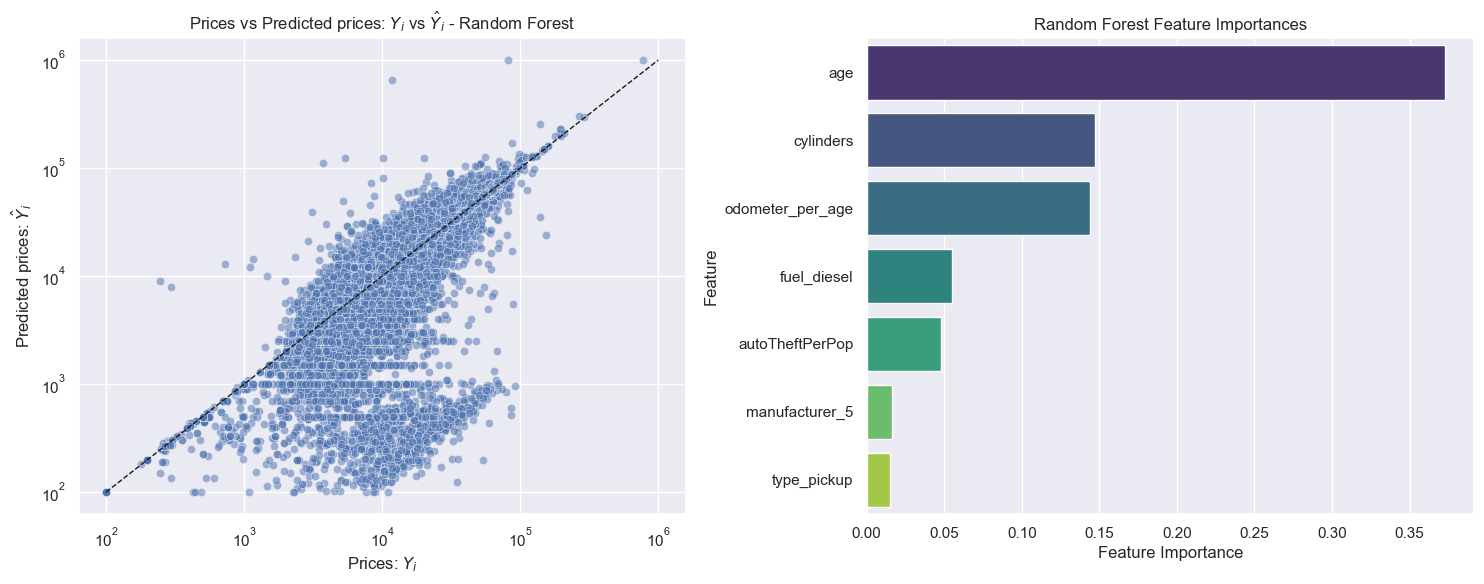

In [95]:
# 랜덤 포레스트 회귀 모델의 예측 결과 시각화
y_test_pred_rf = rf_reg.predict(X_test)

plt_model(rf_reg, y_test, y_test_pred_rf, 'Random Forest', show_feature_importance=True)

### KNN Model

In [86]:
# KNN Regressor 모델 학습
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

In [87]:
# KNN Regressor 모델의 성능 평가
evaluate_model(knn_reg, X_train, X_test, y_train, y_test, 'KNN')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
KNN,2413.76981,3089.984428,3.591467e+07,6.833800e+07,5992.884568,8266.680073,0.852532,0.73735


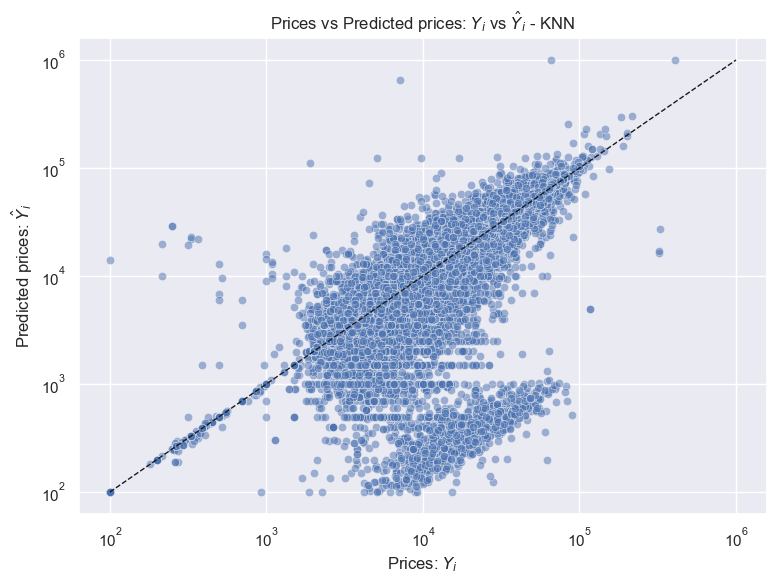

In [88]:
# KNN Regressor 모델의 예측 결과 시각화
y_test_pred_knn = knn_reg.predict(X_test)

plt_model(knn_reg, y_test, y_test_pred_knn, 'KNN')

### XGBoost Regressor Model

In [89]:
from xgboost import XGBRegressor

# XGBoost Regressor 모델 학습
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [90]:
# XGBoost Regressor 모델의 성능 평가
evaluate_model(xgb_reg, X_train, X_test, y_train, y_test, 'XGBoost')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
XGBoost,3405.115129,3555.339047,3.764524e+07,6.015624e+07,6135.571522,7756.045272,0.845426,0.768796


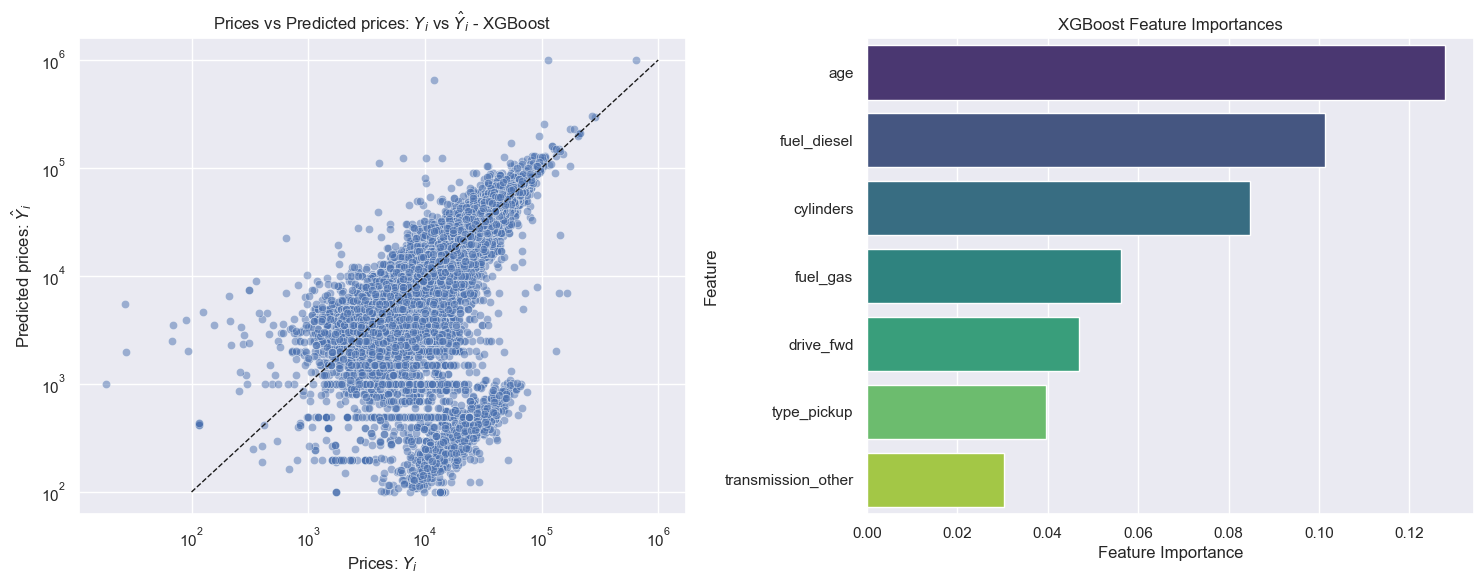

In [91]:
# XGBoost Regressor 모델의 예측 결과 시각화
y_test_pred_xgb = xgb_reg.predict(X_test)

plt_model(xgb_reg, y_test, y_test_pred_xgb, 'XGBoost', show_feature_importance=True)

## 모델별 성능 비교

In [96]:
eval_all_metrics_df = pd.DataFrame(eval_metrics_dict).T
eval_all_metrics_df.loc[['Linear Regression', 'Random Forest', 'KNN', 'XGBoost'], :].sort_values(by='Test R^2', ascending=False)

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Random Forest,824.470582,2171.586579,5.654157e+06,4.563641e+07,2377.847139,6755.472703,0.976784,0.824601
XGBoost,3405.115129,3555.339047,3.764524e+07,6.015624e+07,6135.571522,7756.045272,0.845426,0.768796
KNN,2413.769810,3089.984428,3.591467e+07,6.833800e+07,5992.884568,8266.680073,0.852532,0.737350
Linear Regression,23.581575,23.573064,1.241835e+03,1.250968e+03,35.239684,35.369030,0.554691,0.553304


---

## RandomSearchCV로 최적 hyperparameter 찾기
### 사용된 모델:
- Random Forest Regressor
- XGBoost Regressor
- KNN Regressor

### Random Forest Regressor

In [43]:
# 랜덤 포레스트 회귀 모델의 하이퍼파라미터 튜닝
param_dist = {'n_estimators': [50, 100, 200, 400],
              'max_depth': [5, 10, 20, 40, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

rf_reg_tuned = RandomizedSearchCV(RandomForestRegressor(random_state=42), 
                                  param_distributions=param_dist, n_iter=5, cv=5, 
                                  n_jobs=-1, verbose=1, random_state=42)
rf_reg_tuned.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
rf_reg_tuned.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None}

In [44]:
# 최적의 하이퍼파라미터로 튜닝된 랜덤 포레스트 회귀 모델의 성능 평가
evaluate_model(rf_reg_tuned.best_estimator_, X_train, X_test, y_train, y_test, 'Random Forest Tuned')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
Random Forest Tuned,831.482817,2183.443371,5.477089e+06,4.575566e+07,2340.318054,6764.293047,0.977511,0.824143


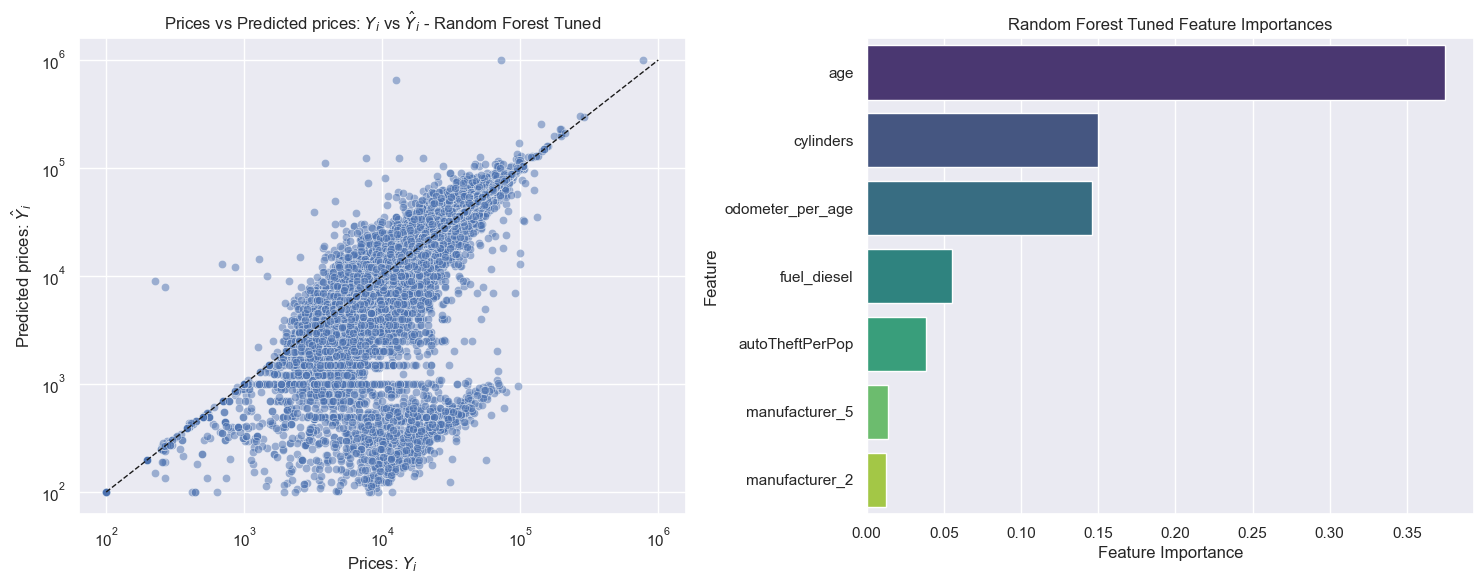

In [67]:
plt_model(rf_reg_tuned.best_estimator_, y_test, rf_reg_tuned.best_estimator_.predict(X_test), 'Random Forest Tuned', show_feature_importance=True)

### KNN Model

In [45]:
# KNN Regressor 모델의 하이퍼파라미터 튜닝
param_dist = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski']}

knn_reg_tuned = RandomizedSearchCV(KNeighborsRegressor(), param_distributions=param_dist, n_iter=5, cv=5, n_jobs=-1, verbose=1, random_state=42)
knn_reg_tuned.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
knn_reg_tuned.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}

In [46]:
# 최적의 하이퍼파라미터로 튜닝된 KNN Regressor 모델의 성능 평가
evaluate_model(knn_reg_tuned.best_estimator_, X_train, X_test, y_train, y_test, 'KNN Tuned')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
KNN Tuned,20.915186,2416.510501,189347.540074,4.900295e+07,435.140828,7000.211047,0.999223,0.811662


### XGBoost Model

In [17]:
# XGBoost Regressor 모델의 하이퍼파라미터 튜닝
param_dist = {'n_estimators': [50, 100, 200, 400],
              'max_depth': [5, 10, 20, 40],
              
              'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'subsample': [0.5, 0.7, 1],
              'colsample_bytree': [0.5, 0.7, 1]}

xgb_reg_tuned = RandomizedSearchCV(XGBRegressor(random_state=42), param_distributions=param_dist, n_iter=5, cv=5, n_jobs=-1, verbose=1, random_state=42)
xgb_reg_tuned.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
xgb_reg_tuned.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'subsample': 1,
 'n_estimators': 400,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5}

In [18]:
# 최적의 하이퍼파라미터로 튜닝된 XGBoost Regressor 모델의 성능 평가
evaluate_model(xgb_reg_tuned.best_estimator_, X_train, X_test, y_train, y_test, 'XGBoost Tuned')

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
XGBoost Tuned,1904.947325,2574.621217,1.202986e+07,4.424377e+07,3468.408759,6651.599051,0.950605,0.829954


## 모델별 성능 비교

In [ ]:
## 모델별 성능 비교
eval_all_metrics_df = pd.DataFrame(eval_metrics_dict).T
eval_all_metrics_df.loc[['Random Forest Tuned', 'KNN Tuned', 'XGBoost Tuned'], :].sort_values(by='Test R^2', ascending=False)

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R^2,Test R^2
XGBoost Tuned,270.925794,2174.389438,4.643575e+05,4.234575e+07,681.437837,6507.360856,0.998093,0.837248
Random Forest Tuned,831.482817,2183.443371,5.477089e+06,4.575566e+07,2340.318054,6764.293047,0.977511,0.824143
KNN Tuned,20.915186,2416.510501,1.893475e+05,4.900295e+07,435.140828,7000.211047,0.999223,0.811662


셋 중에 RMSE가 가장 낮고 $R^2$값이 가장 높은 XGBoost Regressor 모델을 시각화 해보겠습니다.

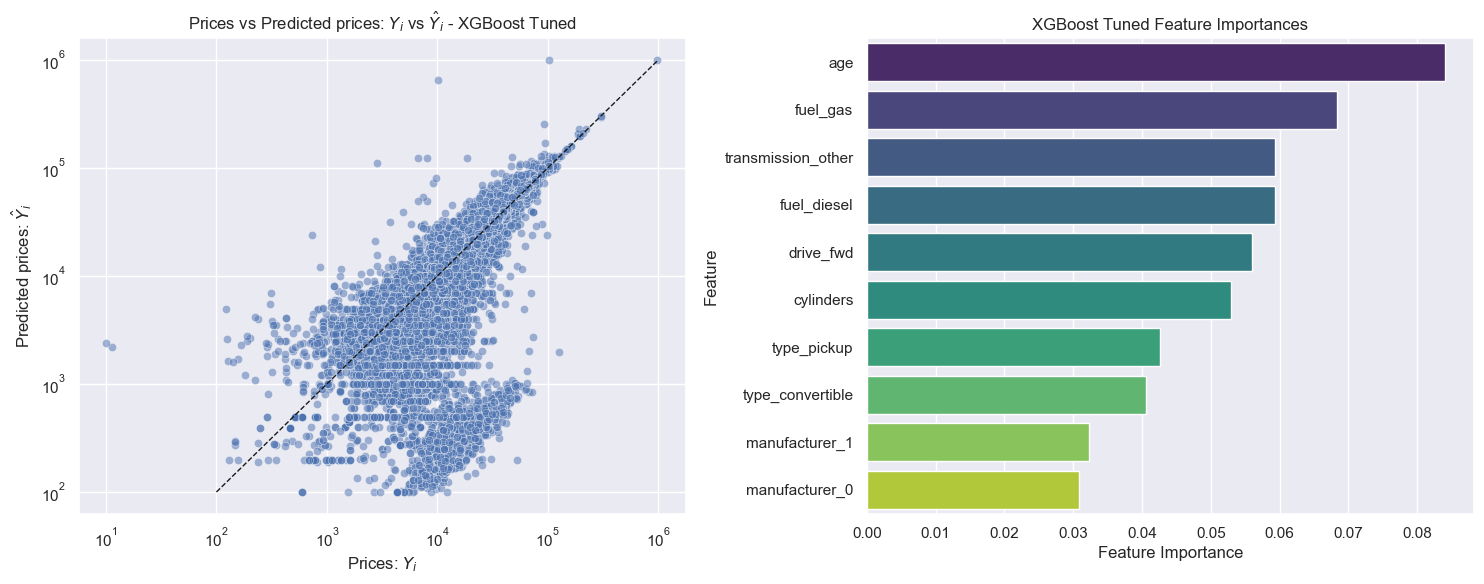

In [19]:
plt_model(xgb_reg_tuned.best_estimator_, y_test, xgb_reg_tuned.best_estimator_.predict(X_test), 'XGBoost Tuned', show_feature_importance=True, n_features=10)

---

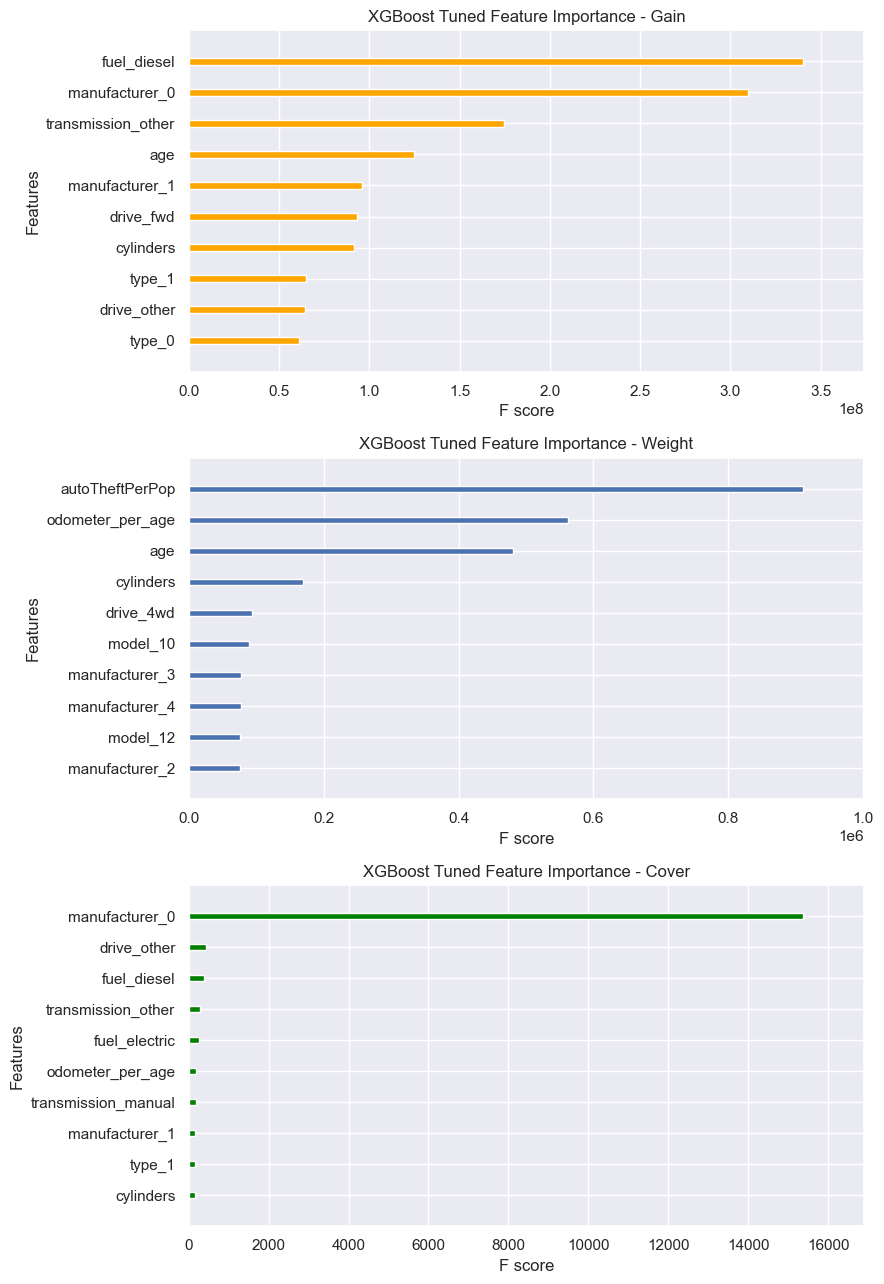

In [50]:
from xgboost import plot_importance

fig, axes = plt.subplots(3, 1, figsize=(9, 13))
plot_importance(xgb_reg_tuned.best_estimator_, importance_type='weight', max_num_features=10, 
                title='XGBoost Tuned Feature Importance - Weight', ax=axes[1], show_values=False)
plot_importance(xgb_reg_tuned.best_estimator_, importance_type='cover', max_num_features=10, 
                title='XGBoost Tuned Feature Importance - Cover', ax=axes[2], color='green', show_values=False)
plot_importance(xgb_reg_tuned.best_estimator_, importance_type='gain', max_num_features=10, 
                title='XGBoost Tuned Feature Importance - Gain', ax=axes[0], color='orange', show_values=False)
plt.tight_layout()
plt.show()

## Feature Selection

방법: Backward Selection(후방 제거) Wrapper 방식
- 모든 변수를 갖고 시작
- 가장 덜 중요한 변수를 하나씩 제거하며 더 이상 성능 향상 없을 때까지 반복

피쳐 중요도를 기준으로 내림차순으로 정렬한 뒤 하나하나 피쳐를 제거하면서 모델의 성능을 테스트 하였습니다.

In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score


# 피쳐 중요도를 내림차순으로 정렬
thresholds = np.sort(list(xgb_reg_tuned.best_estimator_.feature_importances_))

# 가장 성능 좋은 모델 선택
model = xgb_reg_tuned.best_estimator_

# 결과 저장할 리스트 생성
thresh_list = []
r2_list = []
num_features_list = []
features_dropped = []

for i, thresh in enumerate(thresholds):
    
    # 피쳐 중요도에 한계선를 적용하여 피쳐 선택
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train.values)
    
    # 한계선 이상인 피쳐만 선택하여 모델 학습
    selection_model = XGBRegressor(n_estimators=400, max_depth=10, learning_rate=0.1, colsample_bytree=0.5, subsample=1)
    selection_model.fit(select_X_train, y_train)
    
    # 모델 평가
    select_X_test = selection.transform(X_test.values)
    prediction = selection_model.predict(select_X_test)
    score = r2_score(y_test, prediction)
    
    # 결과 저장
    n_features_used = selection.get_feature_names_out(X_train.columns)
    if i > 0:
        features_dropped.append(set(features_used) - set(n_features_used))
    features_used = n_features_used
    thresh_list.append(thresh)
    r2_list.append(score)
    num_features_list.append(select_X_train.shape[1])

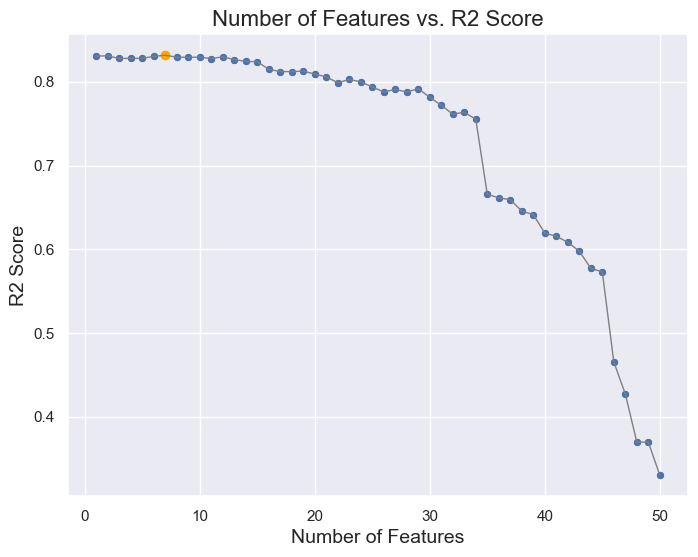

In [84]:
# 피쳐 개수에 따른 R2 점수 시각화
plt.figure(figsize=(8, 6))

sns.scatterplot(x=num_features_list[::-1], y=r2_list)
plt.plot(num_features_list[::-1], r2_list, color='gray', linewidth=1)

# R2 점수가 가장 높은 지점 표시
best_r2_idx = np.argmax(r2_list)
plt.scatter(num_features_list[::-1][best_r2_idx], r2_list[best_r2_idx], color='orange', label='Best R2 Score')

plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('R2 Score', fontsize=14)
plt.title('Number of Features vs. R2 Score', fontsize=16)
plt.grid(True)
plt.show()

In [31]:
# for each entry in feature_used, find out which feature was dropped in the next entry
features_dropped

[{'model_0'},
 {'fuel_electric'},
 {'model_11'},
 {'type_wagon'},
 {'transmission_manual'},
 {'model_1'},
 {'type_hatchback'},
 {'model_9'},
 {'type_other'},
 {'model_2'},
 {'manufacturer_6'},
 {'fuel_hybrid'},
 {'model_12'},
 {'model_10'},
 {'autoTheftPerPop'},
 {'model_3'},
 {'type_truck'},
 {'type_mini-van'},
 {'model_7'},
 {'model_4'},
 {'manufacturer_3'},
 {'type_bus'},
 {'drive_other'},
 {'manufacturer_4'},
 {'model_5'},
 {'transmission_automatic'},
 {'drive_rwd'},
 {'type_offroad'},
 {'model_6'},
 {'manufacturer_5'},
 {'model_8'},
 {'fuel_other'},
 {'manufacturer_2'},
 {'odometer_per_age'},
 {'type_sedan'},
 {'type_SUV'},
 {'drive_awd'},
 {'drive_4wd'},
 {'type_van'},
 {'type_coupe'},
 {'manufacturer_0'},
 {'manufacturer_1'},
 {'type_convertible'},
 {'type_pickup'},
 {'cylinders'},
 {'drive_fwd'},
 {'fuel_diesel'},
 {'transmission_other'},
 {'fuel_gas'}]

In [76]:
# create a new dataframe using r2_list
# column 1: index of list
# column 2: r2 score
# column 3: difference in r2 score

r2_df = pd.DataFrame({'index': range(len(r2_list)), 'r2_score': r2_list})
r2_df['diff_r2'] = r2_df['r2_score'].diff()
r2_df['num_features'] = num_features_list
r2_df['threshold'] = thresh_list

r2_df

,index,r2_score,diff_r2,num_features,threshold
0,0,0.830700,NaN,50,0.004884
1,1,0.830913,0.000213,49,0.005833
2,2,0.827837,-0.003075,48,0.005892
3,3,0.827976,0.000139,47,0.006081
4,4,0.827932,-0.000045,46,0.006650
5,5,0.830317,0.002385,45,0.007529
6,6,0.831656,0.001339,44,0.007551
7,7,0.829338,-0.002317,43,0.007631
8,8,0.829268,-0.000070,42,0.008071
9,9,0.829301,0.000033,41,0.008266


In [75]:
r2_df.sort_values(by='diff_r2', ascending=False).head(10)

,index,r2_score,diff_r2,num_features,threshold
28,28,0.791765,0.003981,29,0.011211
22,22,0.802741,0.003799,23,0.012713
26,26,0.790892,0.003097,27,0.011664
5,5,0.830317,0.002385,6,0.052876
32,32,0.763585,0.002276,33,0.009524
11,11,0.829694,0.001935,12,0.024425
6,6,0.831656,0.001339,7,0.042572
18,18,0.812738,0.000672,19,0.015516
1,1,0.830913,0.000213,2,0.068361
3,3,0.827976,0.000139,4,0.059314


In [83]:
print(feature_dropped[27])
print(feature_dropped[21])
print(feature_dropped[25])
print(feature_dropped[4])
print(feature_dropped[31])

{'type_offroad'}
{'type_bus'}
{'transmission_automatic'}
{'transmission_manual'}
{'fuel_other'}


In [59]:
# change all dtype of features_dropped to string
r2_df['features_dropped'] = r2_df['features_dropped'].astype(str)

KeyError: 'features_dropped'

In [56]:
features_dropped = features_dropped[:-2]

In [23]:
print(len(features_used[0]))
print(len(features_used[1]))

50
49


피쳐 개수를 중요도 순으로 줄일수록 오히려 모델의 성능이 안 좋아지는 것을 볼 수 있습니다.

In [53]:
# 가장 좋은 R2 점수와 제거된 피쳐 이름 출력
best_r2_score = max(r2_list)
best_r2_score_idx = np.argmax(r2_list)
best_num_features = num_features_list[::-1][best_r2_score_idx]
best_thresh = thresh_list[::-1][best_r2_score_idx]

print(f'Best R2 Score: {best_r2_score:.4f}')
print(f'Number of Features: {best_num_features}')
print(f'Threshold: {best_thresh:.4f}')

# 피쳐 중요도에 threshold를 적용하여 피쳐 선택
selection = SelectFromModel(model, threshold=best_thresh, prefit=True)
select_X_train = selection.transform(X_train.values)
select_X_test = selection.transform(X_test.values)

# 선택된 피쳐로 모델 학습 (최적의 파라미터 사용)
selection_model = XGBRegressor(n_estimators=400, max_depth=10, learning_rate=0.1, colsample_bytree=0.5, subsample=1)
selection_model.fit(select_X_train, y_train)

Best R2 Score: 0.8309
Number of Features: 1
Threshold: 0.1432


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# 모델 평가
evaluate_model(selection_model, select_X_train, select_X_test, y_train, y_test, 'XGBoost Tuned Feature Selection')

# 선택된 피쳐로 모델의 예측 결과 시각화
y_test_pred_selection = selection_model.predict(select_X_test)

plt_model(selection_model, y_test, y_test_pred_selection, 'XGBoost Tuned Feature Selection', show_feature_importance=True, n_features=10)

---

### 사용된 모델:
- XGBoost Regressor
- KNN Regressor
- Random Forest Regressor
- LightGBM(?)

1) 최적의 hyperparameter 구하기 (RandomSearchCV)
2) Feature selection: 필요없는 피쳐 제거
3) Overfitting 여부 확인

---
---